In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats as ss
import datetime as dt

from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/ms_wind_curtailment_prediction/curtailment_target_features.csv", sep=";", index_col=0)

## feature lagging

Lagging a time series involves shifting its values forward in time by one or more steps. This means that the observations in the lagged series will appear to have happened later in time compared to the original series. By doing this, we create "lagged" copies of the series, which can be useful for investigating serial dependence or cycles in the time series data. This allows us to incorporate past values of the series into our prediction model, which may help capture patterns or dependencies in the data and improve forecast accuracy.

https://www.kaggle.com/code/ryanholbrook/time-series-as-features

In [6]:
df.drop('actual_solar_MW', axis=1, inplace = True)
df_lagged = pd.DataFrame(index=df.index)

for feature in df.columns:
    df_lagged[feature] = df[feature]
    df_lagged[feature + '_lag1'] = df[feature].shift(1)
    df_lagged[feature + '_lag2'] = df[feature].shift(2)

df_lagged.dropna(inplace = True) # maybe better ways
df_lagged.drop(['level_lag1', 'level_lag2'], axis=1, inplace = True)
df_lagged.drop(['redispatch_lag1', 'redispatch_lag2'], axis=1, inplace = True)


In [ ]:
df_lagged.head()

,redispatch,level,wind_speed_m/s,wind_speed_m/s_lag1,wind_speed_m/s_lag2,wind_direction_degrees,wind_direction_degrees_lag1,wind_direction_degrees_lag2,radiation_global_J/m2,radiation_global_J/m2_lag1,...,actual_solar_MW_lag2,total_grid_load_MWh,total_grid_load_MWh_lag1,total_grid_load_MWh_lag2,residual_load_MWh,residual_load_MWh_lag1,residual_load_MWh_lag2,pumped_storage_MWh,pumped_storage_MWh_lag1,pumped_storage_MWh_lag2
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:30:00,0.0,0.0,2.4,2.7,2.1,240.0,265.0,250.0,0.0,0.0,...,0.0,722.20,727.23,730.95,611.37,620.78,624.18,6.40,4.35,3.25
2020-01-01 00:45:00,0.0,0.0,2.7,2.4,2.7,250.0,240.0,265.0,0.0,0.0,...,0.0,719.22,722.20,727.23,604.33,611.37,620.78,8.32,6.40,4.35
2020-01-01 01:00:00,0.0,0.0,2.7,2.7,2.4,260.0,250.0,240.0,0.0,0.0,...,0.0,717.07,719.22,722.20,600.83,604.33,611.37,6.32,8.32,6.40
2020-01-01 01:15:00,0.0,0.0,2.9,2.7,2.7,260.0,260.0,250.0,0.0,0.0,...,0.0,713.63,717.07,719.22,598.70,600.83,604.33,8.55,6.32,8.32
2020-01-01 01:30:00,0.0,0.0,3.2,2.9,2.7,250.0,260.0,260.0,0.0,0.0,...,0.0,707.65,713.63,717.07,590.62,598.70,600.83,9.12,8.55,6.32


In [8]:
df_lagged.to_csv("/content/drive/MyDrive/ms_wind_curtailment_prediction/lagged_curtailment_target_features.csv", sep=";")

**Features - Analysis of Variance (ANOVA)**

ANOVA because numerical continous variables

Text(0.5, 1.0, 'Top 15 Most Important Features')

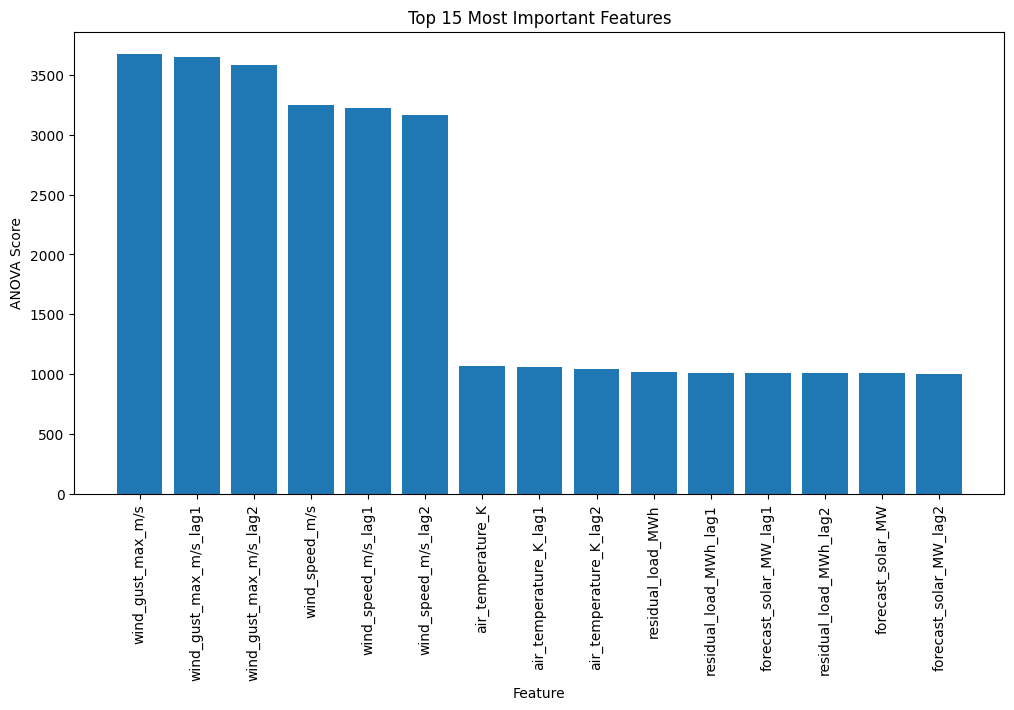

In [ ]:
df.dropna(inplace=True)

X = df_lagged.drop(['redispatch', 'level'], axis = 1)
y = df_lagged['redispatch']

# anova scores
anova = SelectKBest(score_func=f_classif, k=20)
anova.fit(X, y)
anova_scores = anova.scores_

sorted_indices = np.argsort(anova_scores)[::-1]
top_15_indices = sorted_indices[:15]

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_15_indices)), anova_scores[top_15_indices], align='center')
plt.xticks(range(len(top_15_indices)), X.columns[top_15_indices], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('ANOVA Score')
plt.title('Top 15 Most Important Features')

#for feature, score in zip(top_15_features, anova_scores[top_15_indices]):
#    print(f"Feature: {feature}, ANOVA Score: {score.round(2)}")

**Lag plots**

A lag plot visually displays a time series by plotting its values against its corresponding lagged values. By examining a lag plot, one can often identify any patterns or dependencies present in the time series data. Autocorrelation, a common measure of serial dependence, quantifies the correlation between a time series and its lagged versions.

When selecting lags to use as features, it's generally unnecessary to include every lag that exhibits a high autocorrelation. Instead, partial autocorrelation provides a more informative measure. It indicates the correlation of a lag while accounting for the influence of all previous lags, revealing the additional correlation contributed by that specific lag. Essentially, partial autocorrelation helps identify the unique influence of each lag on the time series.

<Figure size 1200x600 with 0 Axes>

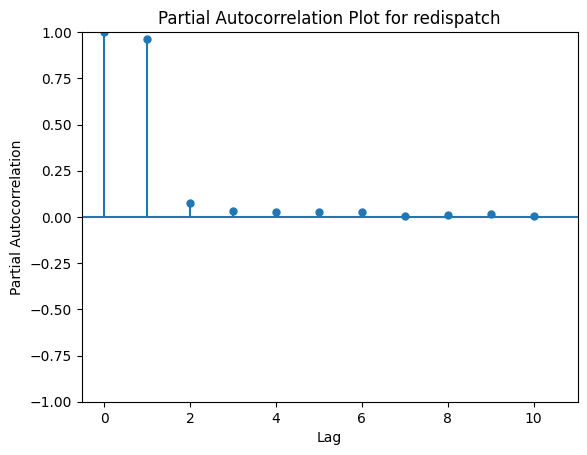

<Figure size 1200x600 with 0 Axes>

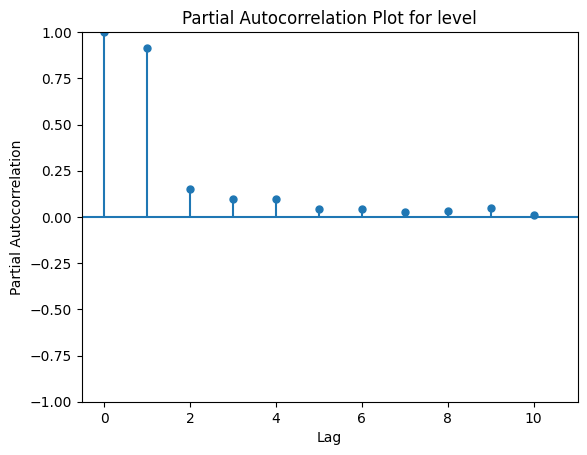

<Figure size 1200x600 with 0 Axes>

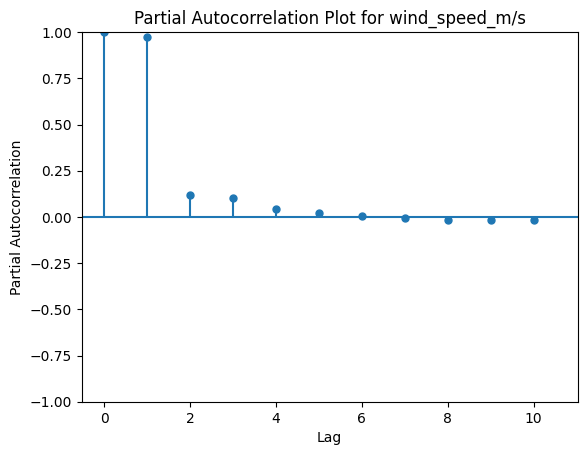

<Figure size 1200x600 with 0 Axes>

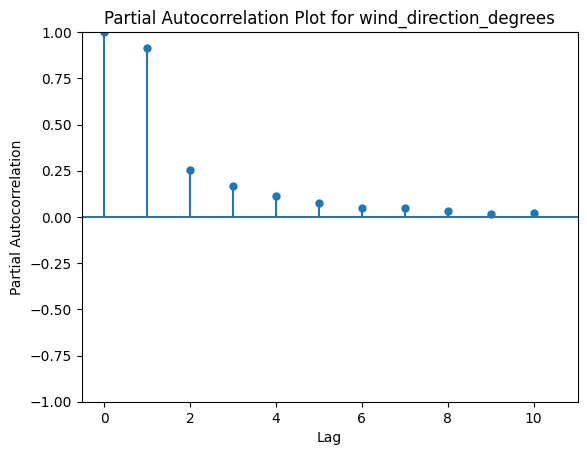

<Figure size 1200x600 with 0 Axes>

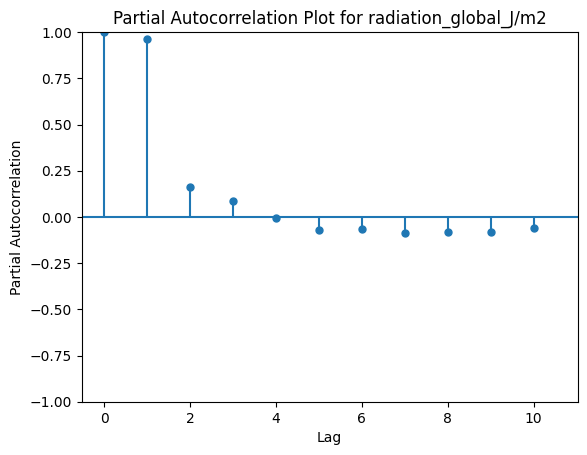

<Figure size 1200x600 with 0 Axes>

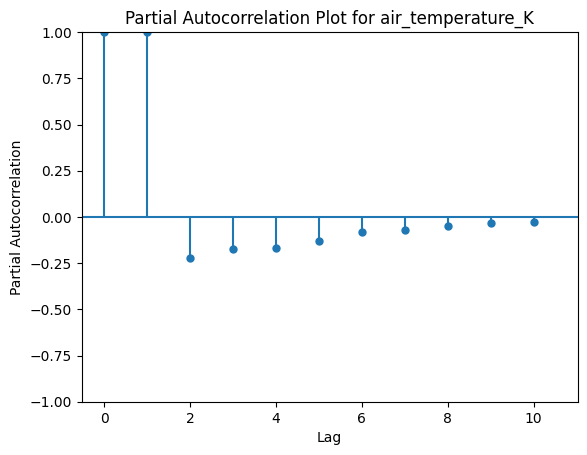

<Figure size 1200x600 with 0 Axes>

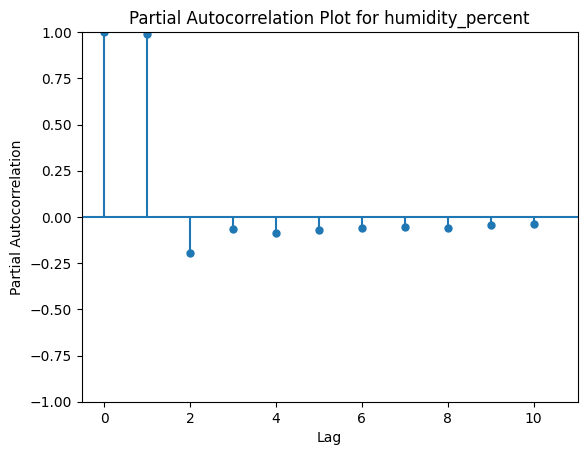

<Figure size 1200x600 with 0 Axes>

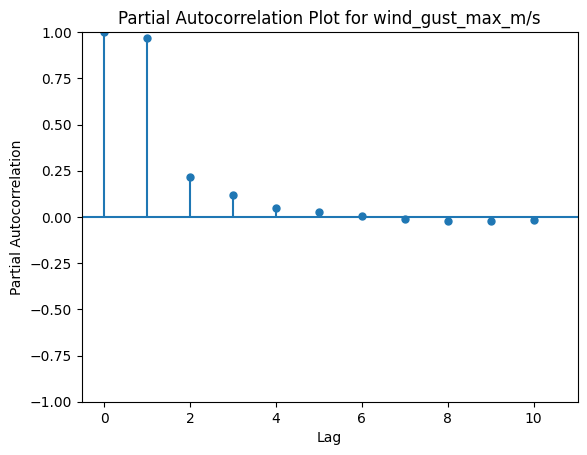

<Figure size 1200x600 with 0 Axes>

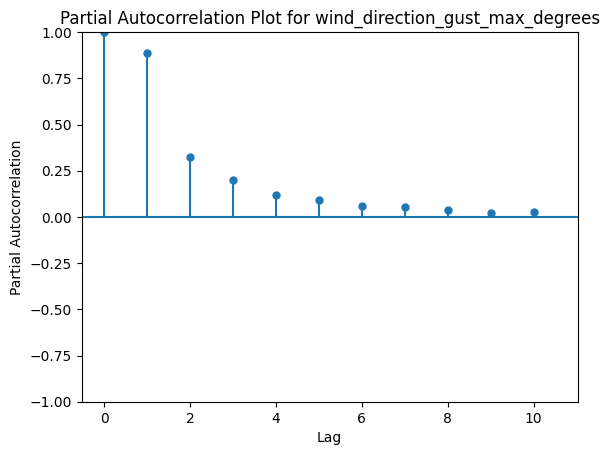

<Figure size 1200x600 with 0 Axes>

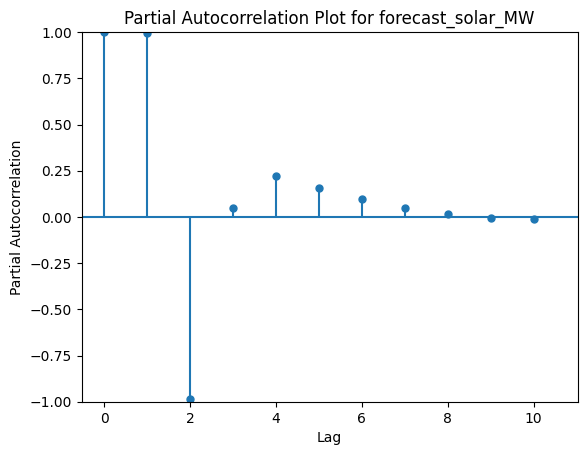

<Figure size 1200x600 with 0 Axes>

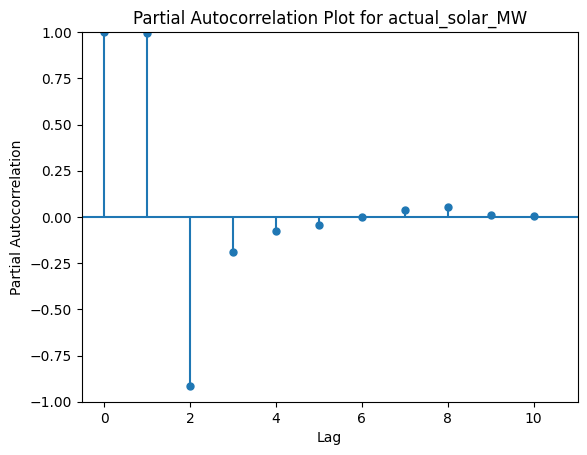

<Figure size 1200x600 with 0 Axes>

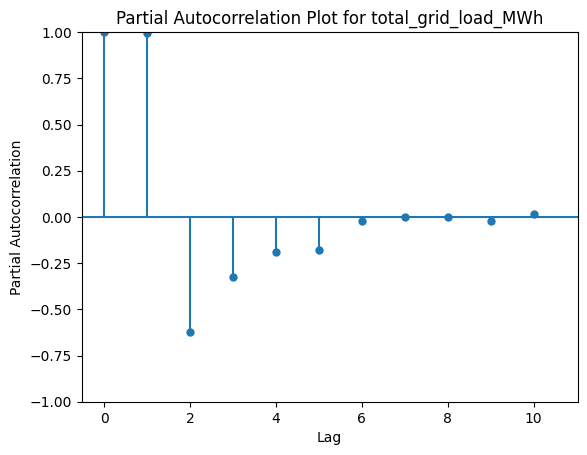

<Figure size 1200x600 with 0 Axes>

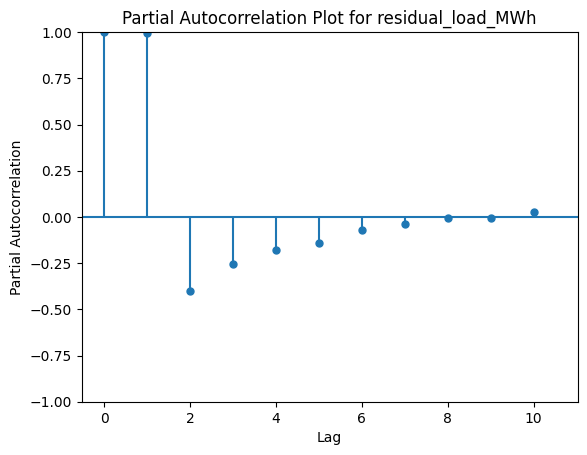

<Figure size 1200x600 with 0 Axes>

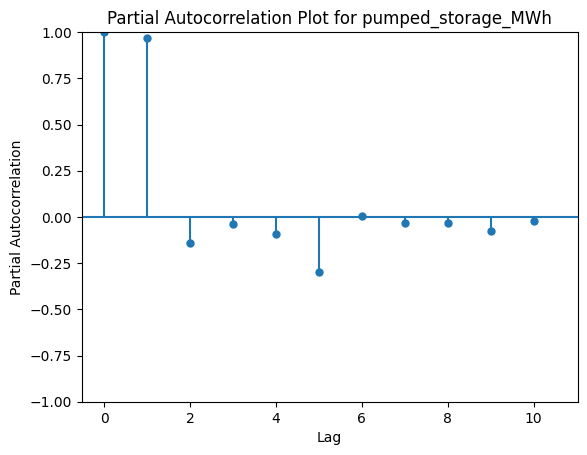

In [ ]:
# Plot partial autocorrelation function for each feature
for feature in df.columns:
    plt.figure(figsize=(12, 6))
    plot_pacf(df[feature], lags=10)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.title(f'Partial Autocorrelation Plot for {feature}')
    plt.show()

## ANOVA feature selection

ANOVA feature selection is a statistical method used to identify the most important features in a dataset by assessing the relationship between a categorical variable (or group) and a numerical variable.

The basic idea behind ANOVA feature selection is to determine whether there is a statistically significant difference in the mean of the numerical variable across different categories or levels of the categorical variable. This is done by calculating the F-statistic, which measures the ratio of the variance between groups to the variance within groups.

The null hypothesis in ANOVA states that there is no significant difference in the means of the numerical variable across the different categories of the categorical variable. A low p-value obtained from the ANOVA test indicates that there is strong evidence against the null hypothesis, suggesting that at least one group mean is significantly different from the others.



In [ ]:
def anova_pvalues(df, cat_col, num_cols):
    """
    This function calculates the ANOVA p-values (probability of no correlation)
    between a categorical column and multiple numerical columns of a DataFrame.
    """
    p_values = {}
    for num_col in num_cols:
        CategoryGroupLists = df.groupby(cat_col)[num_col].apply(list)
        AnovaResults = ss.f_oneway(*CategoryGroupLists)
        p_value = round(AnovaResults[1], 3)
        p_values[num_col] = p_value

    return p_values

In [ ]:
def anova_pvalue(df,cat_col,num_col):
    """
    This function spits out the anova p-value (probability of no correlation)
    between a categorical column and a numerical column of a dataframe
    """
    CategoryGroupLists = df.groupby(cat_col)[num_col].apply(list)
    AnovaResults = ss.f_oneway(*CategoryGroupLists)
    p_value = round(AnovaResults[1],3)
    return p_value

In [ ]:
# Numeric columns to test
numeric_columns = ['wind_speed_m/s', 'wind_speed_m/s_lag1', 'wind_speed_m/s_lag2',
                  'wind_speed_m/s_lag3', 'wind_direction_degrees',
                  'wind_direction_degrees_lag1', 'wind_direction_degrees_lag2',
                  'wind_direction_degrees_lag3', 'radiation_global_J/m2',
                  'radiation_global_J/m2_lag1', 'radiation_global_J/m2_lag2',
                  'radiation_global_J/m2_lag3', 'air_temperature_K',
                  'air_temperature_K_lag1', 'air_temperature_K_lag2',
                  'air_temperature_K_lag3', 'humidity_percent', 'humidity_percent_lag1',
                  'humidity_percent_lag2', 'humidity_percent_lag3', 'wind_gust_max_m/s',
                  'wind_gust_max_m/s_lag1', 'wind_gust_max_m/s_lag2',
                  'wind_gust_max_m/s_lag3', 'wind_direction_gust_max_degrees',
                  'wind_direction_gust_max_degrees_lag1',
                  'wind_direction_gust_max_degrees_lag2',
                  'wind_direction_gust_max_degrees_lag3', 'forecast_solar_MW',
                  'forecast_solar_MW_lag1', 'forecast_solar_MW_lag2',
                  'forecast_solar_MW_lag3', 'actual_solar_MW', 'actual_solar_MW_lag1',
                  'actual_solar_MW_lag2', 'actual_solar_MW_lag3', 'total_grid_load_MWh',
                  'total_grid_load_MWh_lag1', 'total_grid_load_MWh_lag2',
                  'total_grid_load_MWh_lag3', 'residual_load_MWh',
                  'residual_load_MWh_lag1', 'residual_load_MWh_lag2',
                  'residual_load_MWh_lag3', 'pumped_storage_MWh',
                  'pumped_storage_MWh_lag1', 'pumped_storage_MWh_lag2',
                  'pumped_storage_MWh_lag3']

# Calculate ANOVA p-values
p_values = anova_pvalues(df_lagged, 'redispatch', numeric_columns)

# Print the p-values for each numeric column
for num_col, p_value in p_values.items():
    print(f"p-value {num_col}: {p_value}")

In [ ]:
p_value = anova_pvalue(df_lagged, 'redispatch', 'air_temperature_K')
p_value

0.0

In [ ]:
df_lagged[df_lagged['redispatch'] == 1]

,redispatch,redispatch_lag1,redispatch_lag2,redispatch_lag3,wind_speed_m/s,wind_speed_m/s_lag1,wind_speed_m/s_lag2,wind_speed_m/s_lag3,wind_direction_degrees,wind_direction_degrees_lag1,...,total_grid_load_MWh_lag2,total_grid_load_MWh_lag3,residual_load_MWh,residual_load_MWh_lag1,residual_load_MWh_lag2,residual_load_MWh_lag3,pumped_storage_MWh,pumped_storage_MWh_lag1,pumped_storage_MWh_lag2,pumped_storage_MWh_lag3
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-03-20 11:45:00,1.0,0.0,0.0,0.0,4.05,4.20,4.50,4.40,335.0,340.0,...,1101.15,1091.12,721.43,727.32,733.90,734.53,8.90,9.27,7.05,5.55
2020-03-20 12:00:00,1.0,1.0,0.0,0.0,4.10,4.05,4.20,4.50,340.0,335.0,...,1102.77,1101.15,718.03,721.43,727.32,733.90,1.00,8.90,9.27,7.05
2020-03-20 12:15:00,1.0,1.0,1.0,0.0,3.85,4.10,4.05,4.20,330.0,340.0,...,1100.97,1102.77,711.70,718.03,721.43,727.32,1.15,1.00,8.90,9.27
2020-03-20 12:30:00,1.0,1.0,1.0,1.0,3.60,3.85,4.10,4.05,350.0,330.0,...,1101.83,1100.97,699.10,711.70,718.03,721.43,0.43,1.15,1.00,8.90
2020-03-20 12:45:00,1.0,1.0,1.0,1.0,4.55,3.60,3.85,4.10,350.0,350.0,...,1095.87,1101.83,686.55,699.10,711.70,718.03,0.22,0.43,1.15,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-14 15:45:00,1.0,1.0,1.0,1.0,0.50,0.50,0.45,0.40,105.0,360.0,...,1089.73,1095.73,1014.52,1012.85,1009.70,1011.02,0.17,0.18,0.23,0.77
2023-12-14 16:00:00,1.0,1.0,1.0,1.0,0.50,0.50,0.50,0.45,140.0,105.0,...,1090.17,1089.73,1019.70,1014.52,1012.85,1009.70,0.17,0.17,0.18,0.23
2023-12-14 16:15:00,1.0,1.0,1.0,1.0,0.95,0.50,0.50,0.50,125.0,140.0,...,1087.97,1090.17,1027.85,1019.70,1014.52,1012.85,0.13,0.17,0.17,0.18


A p-value of 0.0 typically indicates strong evidence against the null hypothesis, suggesting that there is a significant relationship between the categorical variable ('redispatch') and the numeric features (along with their lagged versions).

In this case, since all the p-values are 0.0, it suggests that there is a significant association between the categorical variable ('redispatch') and each of the numeric features and their lagged versions. This could imply that these features are potentially important predictors for the 'redispatch' variable.